In [2]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import pytensor.tensor.subtensor as st
from itertools import combinations

# 9. Simvastatin*

This one is about factorial designs (2-way ANOVA) with sum-to-zero and corner constraints.

Adapted from [Unit 7: simvastatin.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit7/simvastatin.odc).

Data can be found [here](https://raw.githubusercontent.com/areding/6420-pymc/main/data/simvastatin_data.tsv).

In a quantitative physiology lab II at Georgia Tech, students were asked to find a therapeutic model to test on MC3T3-E1 cell line to enhance osteoblastic growth. The students found a drug called Simvastatin, a cholesterol lowering drug to test on these cells. Using a control and three different concentrations, $10^{-9}$, $10^{-8}$ and $10^{-7}$ M, cells were treated with the drug. These cells were plated on four, 24 well plates with each well plate having a different treatment. 

To test for osteoblastic differentiation, an assay (pNPP) was used to test for alkaline phosphatase activity. The higher the alkaline phosphatase activity the better the cells are differentiating, and become more bone like. This assay was performed 6 times total within 11 days. Each time the assay was performed, four wells from each plate were used.


```{note}
We can now implement the sum-to-zero (STZ) constraints in PyMC with the [```pm.ZeroSumNormal``` class](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.ZeroSumNormal.html). Previously, we were doing something similar to the corner constraint approach, below, for STZ constraints.
```


In [3]:
data = pd.read_csv("../data/simvastatin_data.tsv", sep="\t")
data.head(3)

,apa,conc,time
0,0.062,1,1
1,0.517,1,1
2,0.261,1,1


In [4]:
# set up alternate coordinates, the ID3 or clusters column
conc_idx, conc = pd.factorize(data["conc"])
time_idx, time = pd.factorize(data["time"])
coords = {"conc": conc, "time": time, "id": data.index}

conc_idx, time_idx, coords

(array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1,
        1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2,
        3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0,
        0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1,
        2, 2, 2, 2, 3, 3, 3, 3]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5]),
 {'conc': Index([1, 2, 3, 4], dtype='int64'),
  'time': Index([1, 2, 3, 4, 5, 6], dtype='int64'),
  'id': RangeIndex(start=0, stop=96, step=1)})

## Model 1 with sum-to-zero constraints

In [5]:
def contrasts(var, index):
    """Calculate differences between levels with names like "alpha[low] - alpha[high]".

    var: pytensor.tensor.var.TensorVariable
    index: pandas.Index
    """
    name = var.name
    for i, j in combinations(range(index.size), 2):
        a, b = index[i], index[j]
        pm.Deterministic(f"{name}[{a}] - {name}[{b}]", var[i] - var[j])


with pm.Model(coords=coords) as m:
    apa_data = pm.Data("apa_data", data.apa.to_numpy())
    time_idx_data = pm.Data("time_idx_data", time_idx, dims="id")
    conc_idx_data = pm.Data("conc_idx_data", conc_idx, dims="id")

    mu0 = pm.Normal("mu0", 0, sigma=10)
    alpha = pm.ZeroSumNormal("alpha", sigma=10, dims="conc")
    beta = pm.ZeroSumNormal("beta", sigma=10, dims="time")
    alphabeta = pm.ZeroSumNormal(
        "alphabeta", sigma=10, dims=("conc", "time"), n_zerosum_axes=2
    )

    sigma = pm.Exponential("sigma", 0.05)

    mu = (
        mu0
        + alpha[conc_idx_data]
        + beta[time_idx_data]
        + alphabeta[conc_idx_data, time_idx_data]
    )
    pm.Normal("apa", mu, sigma=sigma, observed=apa_data, dims="id")

    # calculate differences between levels (except interaction term)
    contrasts(alpha, coords["conc"])
    contrasts(beta, coords["time"])

    trace = pm.sample(2000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu0, alpha, beta, alphabeta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


In [6]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu0,0.239,0.025,0.192,0.284,0.000,0.000,16025.0,6047.0,1.0
alpha[1],0.050,0.043,-0.029,0.130,0.000,0.000,16137.0,5345.0,1.0
alpha[2],0.068,0.044,-0.015,0.151,0.000,0.000,17739.0,6112.0,1.0
alpha[3],-0.075,0.043,-0.155,0.008,0.000,0.000,15878.0,5571.0,1.0
alpha[4],-0.042,0.043,-0.122,0.040,0.000,0.000,16277.0,6767.0,1.0
beta[1],0.046,0.057,-0.064,0.151,0.000,0.001,17607.0,5500.0,1.0
beta[2],-0.150,0.056,-0.255,-0.043,0.000,0.000,16229.0,5287.0,1.0
beta[3],-0.017,0.057,-0.124,0.089,0.000,0.001,15903.0,5838.0,1.0
beta[4],0.231,0.056,0.127,0.338,0.000,0.000,20296.0,6065.0,1.0
beta[5],-0.023,0.056,-0.130,0.080,0.000,0.001,17988.0,5377.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

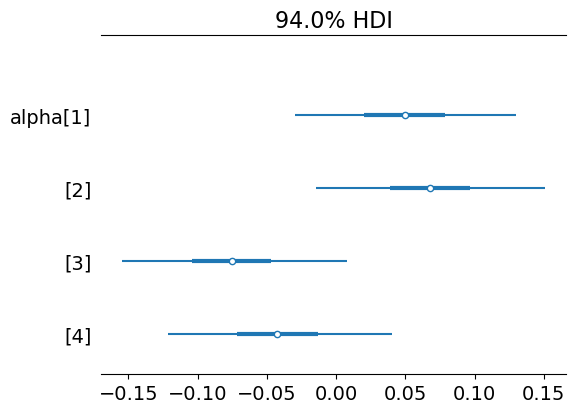

In [7]:
az.plot_forest(trace, var_names=["alpha"], combined=True)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

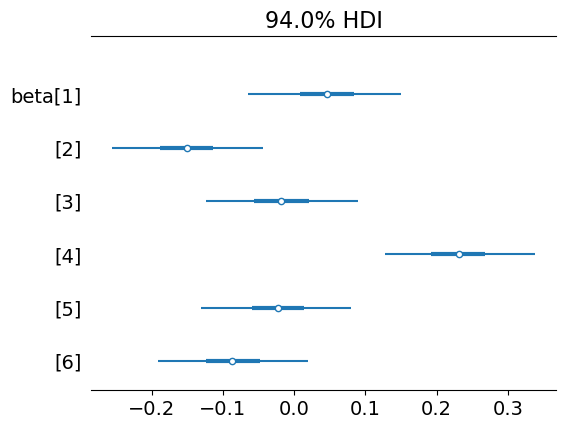

In [8]:
az.plot_forest(trace, var_names=["beta"], combined=True)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

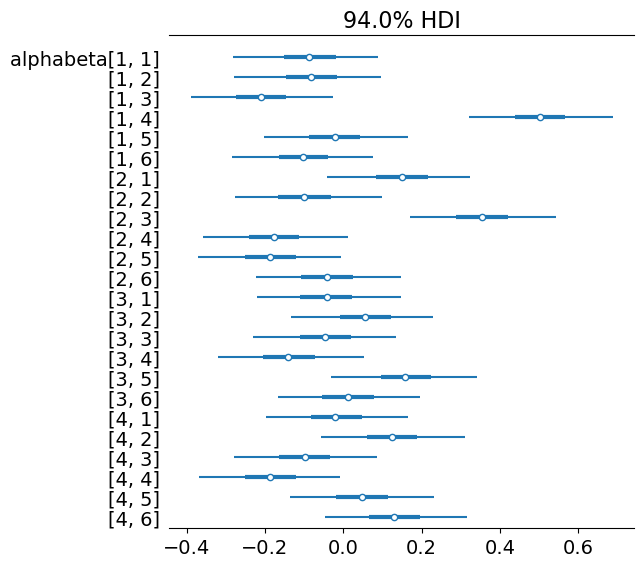

In [9]:
az.plot_forest(trace, var_names=["alphabeta"], combined=True)

## Model 2 with corner constraints

In [10]:
with pm.Model(coords=coords) as m:
    apa_data = pm.Data("apa_data", data.apa.to_numpy())
    time_idx_data = pm.Data("time_idx_data", time_idx, dims="id")
    conc_idx_data = pm.Data("conc_idx_data", conc_idx, dims="id")

    mu0 = pm.Normal("mu0", 0, tau=0.0001)
    _alpha = pm.Normal("_alpha", 0, tau=0.0001, dims="conc")
    _beta = pm.Normal("_beta", 0, tau=0.0001, dims="time")
    _alphabeta = pm.Normal("_alphabeta", 0, tau=0.0001, dims=("conc", "time"))
    tau = pm.Gamma("tau", 0.001, 0.001)
    sigma = pm.Deterministic("sigma", 1 / tau**0.5)

    # corner constraints: sets the first element of a dimension to zero
    alpha = pm.Deterministic("alpha", st.set_subtensor(_alpha[0], 0), dims="conc")
    beta = pm.Deterministic("beta", st.set_subtensor(_beta[0], 0), dims="time")
    _alphabeta = st.set_subtensor(_alphabeta[:, 0], 0)
    alphabeta = pm.Deterministic(
        "alphabeta",
        st.set_subtensor(_alphabeta[0, :], 0),
        dims=("conc", "time"),
    )

    mu = (
        mu0
        + alpha[conc_idx_data]
        + beta[time_idx_data]
        + alphabeta[conc_idx_data, time_idx_data]
    )
    pm.Normal("apa", mu, tau=tau, observed=apa_data, dims="id")

    contrasts(alpha, coords["conc"])
    contrasts(beta, coords["time"])

    trace = pm.sample(2000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu0, _alpha, _beta, _alphabeta, tau]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


In [11]:
az.summary(trace, var_names="~_", filter_vars="like", kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu0,0.246,0.125,0.009,0.478
tau,17.175,2.895,11.826,22.607
sigma,0.244,0.021,0.206,0.283
alpha[1],0.000,0.000,0.000,0.000
alpha[2],0.255,0.174,-0.066,0.587
alpha[3],-0.080,0.177,-0.419,0.250
alpha[4],-0.023,0.176,-0.359,0.304
beta[1],0.000,0.000,0.000,0.000
beta[2],-0.188,0.174,-0.503,0.154
beta[3],-0.187,0.176,-0.508,0.156


In [12]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Sun Mar 09 2025

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

pymc    : 5.19.1
numpy   : 1.26.4
pandas  : 2.2.3
arviz   : 0.20.0
pytensor: 2.26.4

